# Binary Classification of Machine Failures

## Index <a id="index"></a>

- [Libraries](#libraries)
- [Import Data](#import_data)
- [Data Cleaning](#data_cleaning)
- [Exploratory Data Analysis](#eda)
- [Preprocessing](#preprocessing)
- [PCA Analysis](#pca)
- [Model](#model)
- [Save Predictions](#savepreds)

## Libraries <a id="libraries"></a>

[Return to Index](#index)

In [1]:
import os

In [2]:
if 'source' not in os.listdir():
    os.chdir('..')

In [79]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from source.model_toolkit import models as mods

In [57]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [5]:
import lightgbm as lgb

## Import Data <a id="import_data"></a>

[Return to Index](#index)

In [6]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [7]:
train_data

id Product ID Type  Air temperature [K]  Process temperature [K]  \
0            0     L50096    L                300.6                    309.6   
1            1     M20343    M                302.6                    312.1   
2            2     L49454    L                299.3                    308.5   
3            3     L53355    L                301.0                    310.9   
4            4     M24050    M                298.0                    309.0   
...        ...        ...  ...                  ...                      ...   
136424  136424     M22284    M                300.1                    311.4   
136425  136425     H38017    H                297.5                    308.5   
136426  136426     L54690    L                300.5                    311.8   
136427  136427     L53876    L                301.7                    310.9   
136428  136428     L47937    L                296.9                    308.1   

        Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
0                         1596         36.1              140                0   
1                         1759         29.1              200                0   
2                         1805         26.5               25                0   
3                         1524         44.3              197                0   
4                         1641         35.4               34                0   
...                        ...          ...              ...              ...   
136424                    1530         37.5              210                0   
136425                    1447         49.1                2                0   
136426                    1524         38.5              214                0   
136427                    1447         46.3               42                0   
136428                    1557         39.3              229                0   

        TWF  HDF  PWF  OSF  RNF  
0         0    0    0    0    0  
1         0    0    0    0    0  
2         0    0    0    0    0  
3         0    0    0    0    0  
4         0    0    0    0    0  
...     ...  ...  ...  ...  ...  
136424    0    0    0    0    0  
136425    0    0    0    0    0  
136426    0    0    0    0    0  
136427    0    0    0    0    0  
136428    0    0    0    0    0  

[136429 rows x 14 columns]

## Data Cleaning <a id="data_cleaning"></a>

[Return to Index](#index)

The training data contains **136429** rows.

In [8]:
len(train_data)

136429

In [9]:
train_data.dtypes

id                           int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

The training data contains **no nulls** on any columnn

In [10]:
pd.isnull(train_data).sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

**Product ID** column contains **9976** unique values. Each contains less than **1%** rows. We should not use this variable.

In [11]:
train_data['Product ID'].value_counts(normalize = True)

Product ID
L53257    0.001019
L49056    0.000960
L53271    0.000960
L54275    0.000880
L48892    0.000880
            ...   
M24614    0.000007
H39399    0.000007
M15853    0.000007
H32637    0.000007
L48036    0.000007
Name: proportion, Length: 9976, dtype: float64

**Type** column contains **3** unique values, 'L', 'M' and 'H'.

In [12]:
train_data['Type'].value_counts(normalize = True)

Type
L    0.698928
M    0.235668
H    0.065404
Name: proportion, dtype: float64

The dataset is very **unbalanced**. Class balancing must be done.

In [13]:
train_data['Machine failure'].value_counts(normalize = True)

Machine failure
0    0.984256
1    0.015744
Name: proportion, dtype: float64

## Exploratory Data Analysis <a id="eda"></a>

[Return to Index](#index)

Define numerical and categorical columns

In [14]:
train_data.columns

Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [15]:
exclude_cols = ['id', 'Product ID', 'Machine failure']

categorical_cols = ['Type', 'TWF', 'HDF' ,'PWF', 'OSF', 'RNF']

numerical_cols = [col for col in train_data.columns if col not in exclude_cols + categorical_cols]

### Numerical Columns

In [16]:
def boxplot_bytarget(df, cols, target_var, **kwargs):
    ylabels = df[target_var].unique()
    
    for i in range(len(cols)):
        fig, ax = plt.subplots()
        ax.boxplot([df[df[target_var] == ylabel][cols[i]] for ylabel in ylabels], **kwargs)
        
        ax.set_ylabel(cols[i])
        ax.set_xlabel(target_var)
        
        ax.set_xticklabels(ylabels)
        
        ax.set_title(f'Boxplot of {cols[i]} by {target_var}') 
        plt.show()

In [17]:
def hist_bytarget(df, cols, target_var, **kwargs):
    ylabels = df[target_var].unique()
    
    for i in range(len(cols)):
        fig, ax = plt.subplots()
        for ylabel in ylabels:
            ax.hist(df[df[target_var] == ylabel][cols[i]], label = ylabel, **kwargs)
        
        ax.set_xlabel(cols[i])
        ax.set_ylabel('Relative Frequency')
        
        ax.legend()
        ax.set_title(f'Histogram of {cols[i]} by {target_var}')
        
        plt.show()

In [18]:
def plot_corrmatrix(df, cols):
    data = df[cols].corr()
    
    fig, ax = plt.subplots()
    
    cax = ax.matshow(data)
    
    ax.set_xticks(range(len(numerical_cols)), labels = numerical_cols, rotation = 45)
    ax.set_yticks(range(len(numerical_cols)), labels = numerical_cols)

    for (i, j), value in np.ndenumerate(data):
        ax.text(i, j, f'{round(value, 2)}')
    
    ax.set_title('Correlation Matrix')
    fig.colorbar(cax)
    
    plt.show()

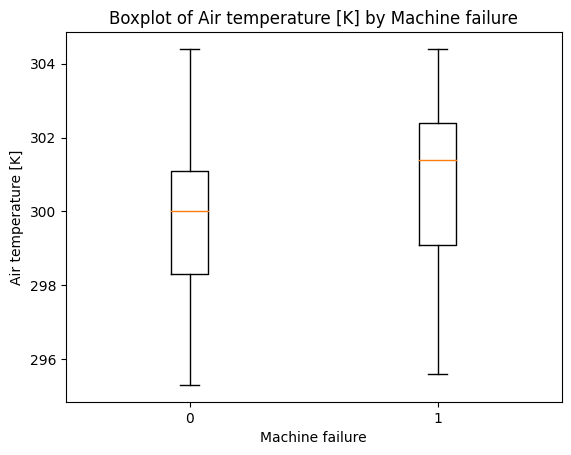

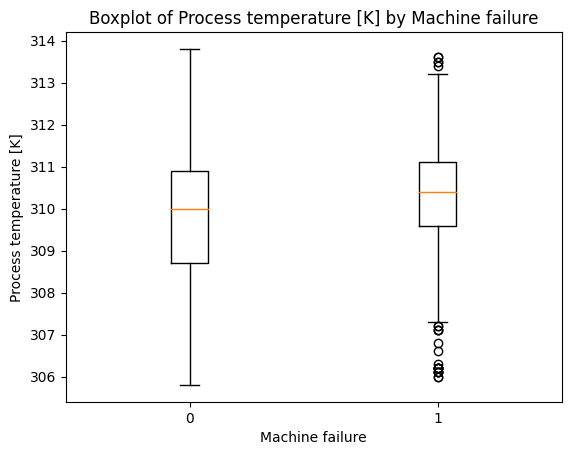

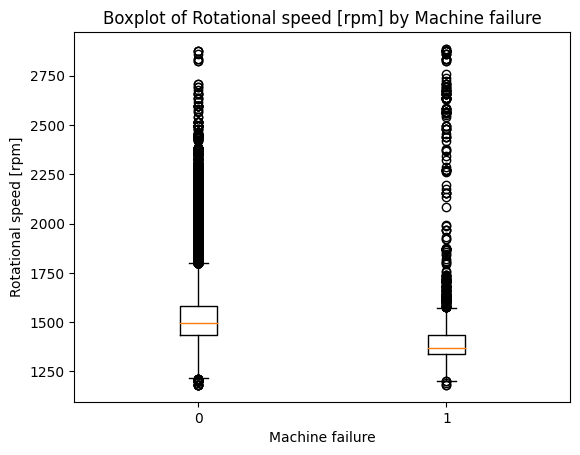

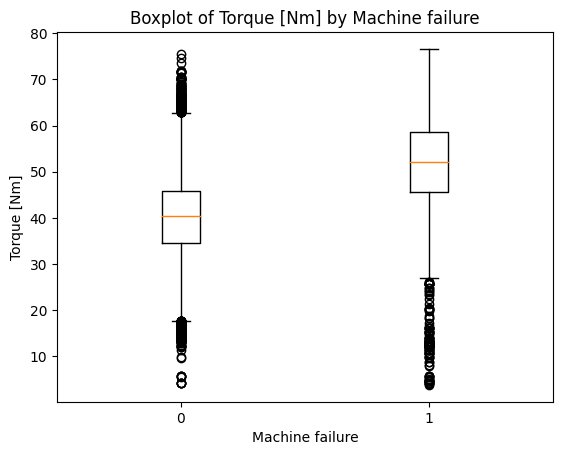

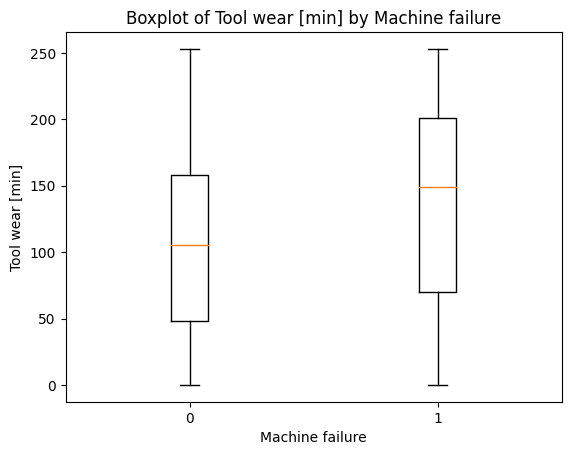

In [19]:
boxplot_bytarget(train_data, numerical_cols, 'Machine failure')

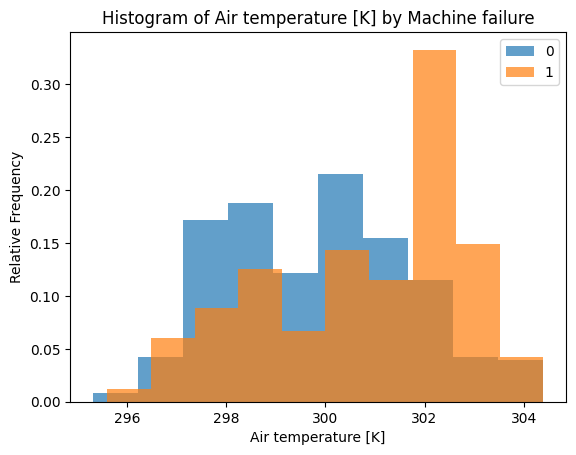

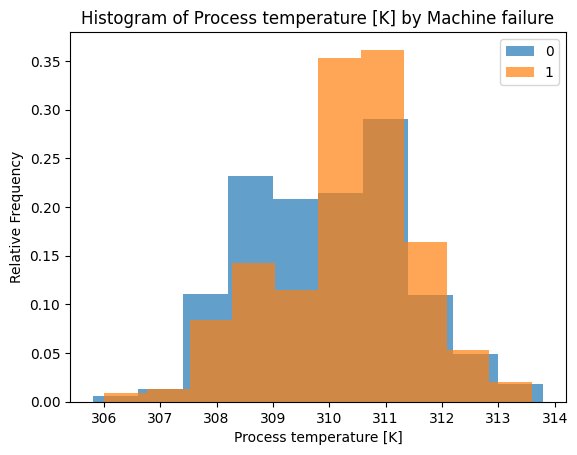

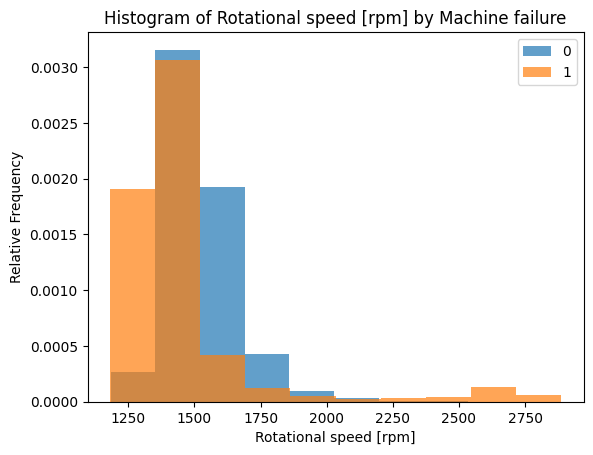

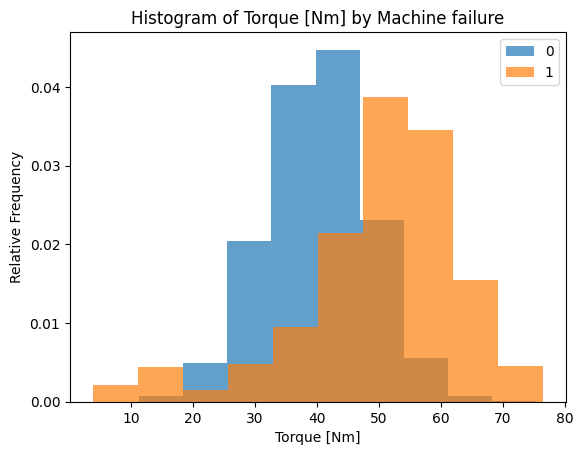

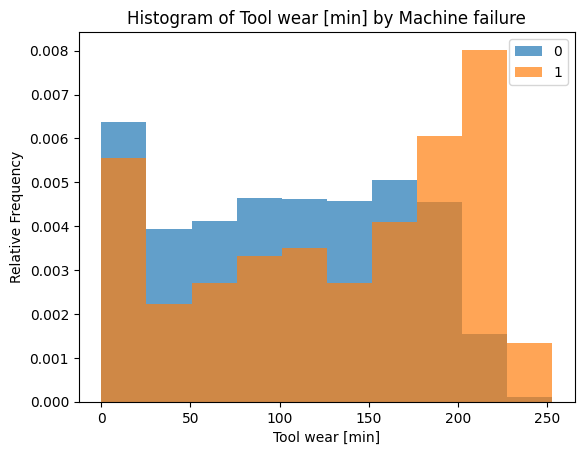

In [20]:
hist_bytarget(train_data, numerical_cols, 'Machine failure', density = True, alpha = 0.7)

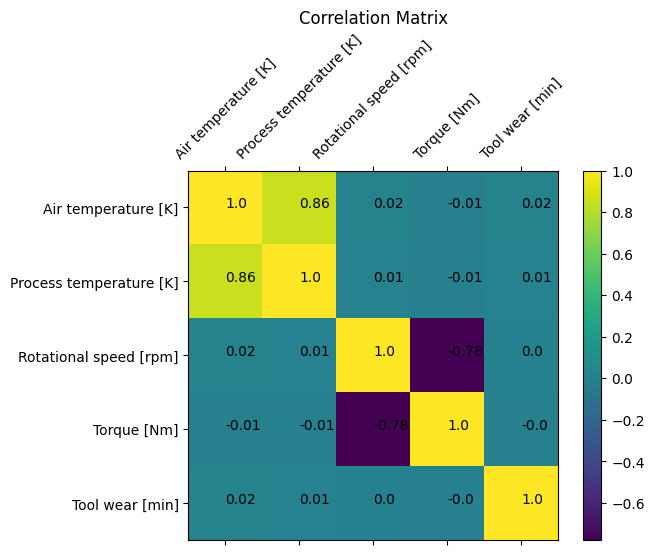

In [21]:
plot_corrmatrix(train_data, numerical_cols)

### Categorical Columns

In [22]:
def bar_bytarget(df, cols, target_var):
    ylabels = df[target_var].unique()
    
    for col in cols:
        xlabels = df[col].unique()
        data = df.groupby(col)[target_var].agg('mean')
        
        fig, ax = plt.subplots()
        
        bax = ax.bar(xlabels, data)
        
        ax.set_xticks(xlabels)
        
        ax.set_xlabel(col)
        ax.set_ylabel(f'Average {target_var}')
        
        ax.set_title(f'Average {target_var} by {col}')
        
        plt.show()

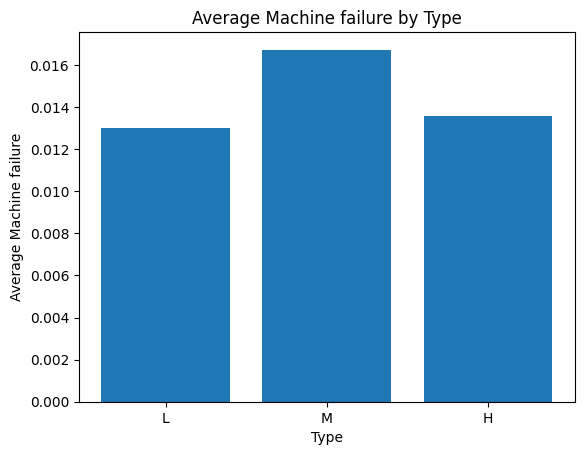

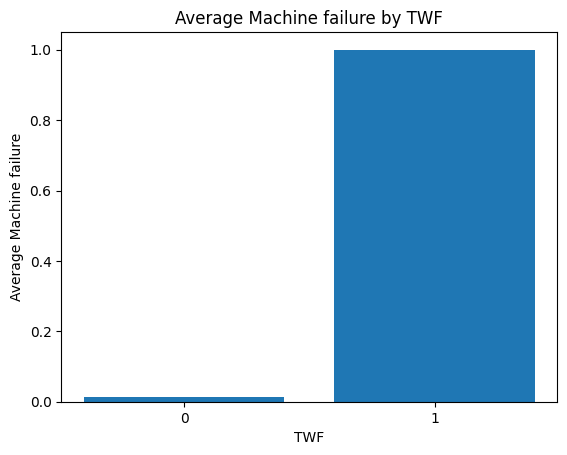

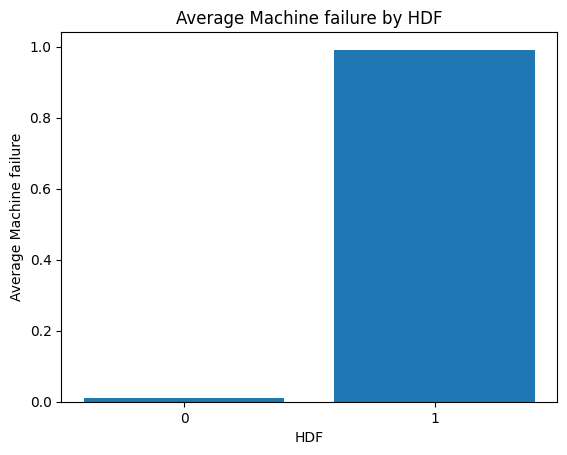

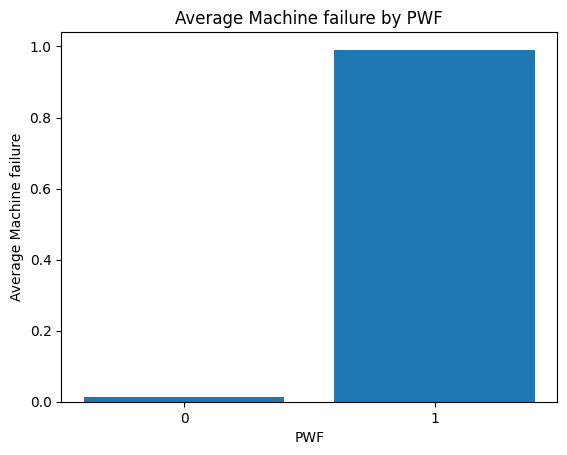

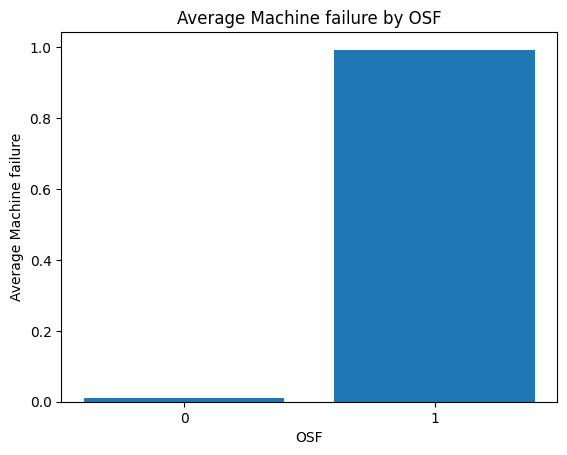

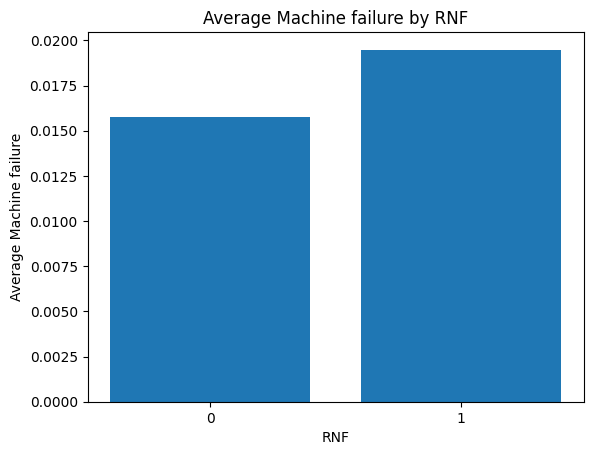

In [23]:
bar_bytarget(train_data, categorical_cols, 'Machine failure')

## Preprocessing <a id="preprocessing"></a>

[Return to Index](#index)

Selection of final columns

In [24]:
categorical_features = categorical_cols
numerical_features = numerical_cols

### Train-Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data[numerical_features + categorical_features],
    train_data['Machine failure'],
    train_size = 0.7, 
    random_state = 23,
    stratify = train_data['Machine failure']
)

## PCA Analysis <a id="pca"></a>

[Return to Index](#index)

In [30]:
pca = Pipeline(
    [
        (
            'column_transformer',
            ColumnTransformer(
                [
                    (
                        'numeric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'mean')),
                                ('scale', StandardScaler())
                            ]
                        ),
                        numerical_features
                    ),
                    (
                        'categoric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'most_frequent')),
                                ('encode', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'))
                            ]
                        ),
                        categorical_features
                    )
                ]
            )
        ),
        ('pca', PCA())
    ]
)
pca.fit(X_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('categoric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'TWF', 'HDF', 'PWF',
                                                   'OSF', 'RNF'])])),
                ('pca', PCA())])

In [31]:
def plot_PCA(df, y, target_var):
    ylabels = y.unique()
    
    fig, ax = plt.subplots()
    
    for ylabel in ylabels:
        ax.scatter(df[y == ylabel, 0], df[y == ylabel, 1], label = ylabel)
    
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    
    ax.legend()
    ax.set_title(f'First 2 Principal components by {target_var}')
    
    plt.show()    

We'll plot the first two Principal Components

There doesn't to be a distinct boundary between the classes but the values of each respective class seem to be mostly grouped together. KNN could work well to predict class

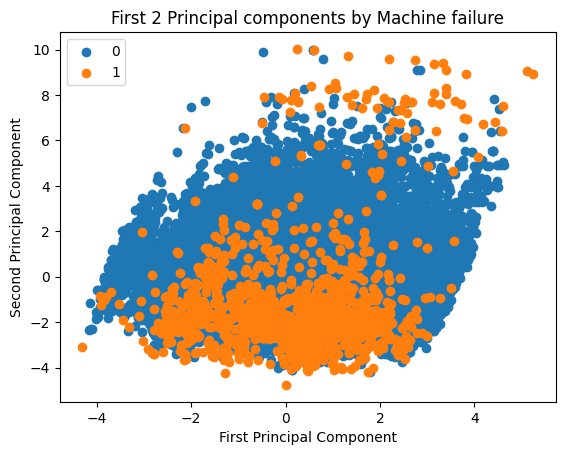

In [32]:
plot_PCA(pca.transform(X_train), y_train, 'Machine failure')

As we plot the Explained variance of the PCA, we can see that the first four components explain more than 90% of the variance.

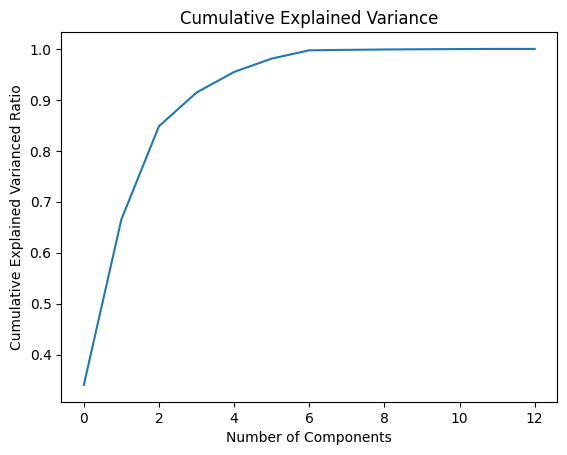

In [46]:
fig, ax = plt.subplots()

ax.plot(pca.steps[1][1].explained_variance_ratio_.cumsum())

ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Varianced Ratio')

ax.set_title('Cumulative Explained Variance')

plt.show()

## Model <a id="model"></a>

- [K Nearest Neighbors](#knn)
- [LightGBM](#lightgbm)
- [Final Model](#finalmodel)
- [Evaluate Model](#evaluate)

[Return to Index](#index)

We create a cv instance to train our models

In [47]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 23)

### K Nearest Neighbors <a id="knn"></a>

[Back to Model](#model)

In [48]:
knn_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

In [49]:
knn_estimator = Pipeline(
    [
        (
            'column_transformer',
            ColumnTransformer(
                [
                    (
                        'numeric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'mean')),
                                ('scale', StandardScaler())
                            ]
                        ),
                        numerical_features
                    ),
                    (
                        'categoric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'most_frequent')),
                                ('encode', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'))
                            ]
                        ),
                        categorical_features
                    )
                ]
            )
        ),
        ('knn', KNeighborsClassifier())
    ]
)

In [50]:
knn = GridSearchCV(
    estimator = knn_estimator,
    param_grid = knn_grid,
    scoring = 'average_precision',
    cv = cv,
    refit = True
)

In [51]:
knn.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=23, shuffle=True),
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['Air '
                                                                          'temperature '
                                                                          '[K]',
                                                                          'Process '
                                                                          'temperature '
                                                                          '[K]',
                                                                          'Rotational '
                                                                          'speed '
                                                                          '[rpm]',
                                                                          'Torque '
                                                                          '[Nm]',
                                                                          'Tool '
                                                                          'wear '
                                                                          '[min]']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encode',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'TWF',
                                                                          'HDF',
                                                                          'PWF',
                                                                          'OSF',
                                                                          'RNF'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7],
                         'knn__weights': ['uniform', 'distance']},
             scoring='average_precision')

In [85]:
knn_best_params = {key.split('__')[-1]: value for key, value in knn.best_params_.items()}
print(knn_best_params)

{'n_neighbors': 7, 'weights': 'distance'}


In [53]:
best_knn = knn.best_estimator_

ROC AUC

In [54]:
roc_auc_score(y_test, best_knn.predict_proba(X_test)[:, 1])

0.8664400270741773

PR AUC

In [55]:
average_precision_score(y_test, best_knn.predict_proba(X_test)[:, 1])

0.7121686539816201

### LightGBM <a id="lightgbm"></a>

[Back to Model](#model)

In [89]:
lgbm_grid = [
    {
        'lgbm__max_depth': [-1],
        'lgbm__num_leaves': [50, 75, 100],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [3],
        'lgbm__num_leaves': [10, 20, 30],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [5],
        'lgbm__num_leaves': [20, 30, 40],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [7],
        'lgbm__num_leaves': [30, 40, 50],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [-1],
        'lgbm__num_leaves': [50, 75, 100],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [3],
        'lgbm__num_leaves': [10, 20, 30],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [5],
        'lgbm__num_leaves': [20, 30, 40],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [7],
        'lgbm__num_leaves': [30, 40, 50],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [-1],
        'lgbm__num_leaves': [50, 75, 100],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [3],
        'lgbm__num_leaves': [10, 20, 30],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.01],
        'lgbm__n_estimators': [100, 120, 150]
    },
    {
        'lgbm__max_depth': [5],
        'lgbm__num_leaves': [20, 30, 40],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.01],
        'lgbm__n_estimators': [100, 120, 150]
    },
    {
        'lgbm__max_depth': [7],
        'lgbm__num_leaves': [30, 40, 50],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.01],
        'lgbm__n_estimators': [100, 120, 150]
    },
]

In [90]:
lgbm_estimator = Pipeline(
    [
        (
            'column_transformer',
            ColumnTransformer(
                [
                    (
                        'numeric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'mean')),
                                ('scale', StandardScaler())
                            ]
                        ),
                        numerical_features
                    ),
                    (
                        'categoric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'most_frequent')),
                                (
                                    'encode', OrdinalEncoder(
                                        handle_unknown = 'use_encoded_value', 
                                        unknown_value = -1
                                    )
                                )
                            ]
                        ),
                        categorical_features
                    )
                ]
            )
        ),
        ('lgbm', lgb.LGBMClassifier(random_state = 23, is_unbalance = True))
    ]
)

In [91]:
lgbm = RandomizedSearchCV(
    lgbm_estimator,
    n_iter = 50,
    param_distributions = lgbm_grid,
    scoring = 'average_precision',
    cv = cv,
    random_state = 23,
    refit = True
)

In [92]:
lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=23, shuffle=True),
                   estimator=Pipeline(steps=[('column_transformer',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                StandardScaler())]),
                                                                               ['Air '
                                                                                'temperature '
                                                                                '[K]',
                                                                                'Process '
                                                                                'temperature '
                                                                                '[K]',
                                                                                'Rotational '
                                                                                'speed '
                                                                                '[rpm]',
                                                                                'Torque '
                                                                                '[Nm]',
                                                                                'Tool '
                                                                                'wear '
                                                                                '[min]']),
                                                                              (...
                                         'lgbm__n_estimators': [100, 120, 150],
                                         'lgbm__num_leaves': [20, 30, 40],
                                         'lgbm__subsample': [0.5, 0.7, 1]},
                                        {'lgbm__colsample_bytree': [0.6, 0.8,
                                                                    1],
                                         'lgbm__learning_rate': [0.01],
                                         'lgbm__max_bin': [150, 200, 255],
                                         'lgbm__max_depth': [7],
                                         'lgbm__n_estimators': [100, 120, 150],
                                         'lgbm__num_leaves': [30, 40, 50],
                                         'lgbm__subsample': [0.5, 0.7, 1]}],
                   random_state=23, scoring='average_precision')

In [93]:
lgbm_best_params = {key.split('__')[-1]: value for key, value in lgbm.best_params_.items()}
print(lgbm_best_params)

{'subsample': 0.7, 'num_leaves': 50, 'n_estimators': 120, 'max_depth': -1, 'max_bin': 200, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [94]:
best_lgbm = lgbm.best_estimator_

ROC AUC

In [95]:
roc_auc_score(y_test, best_lgbm.predict_proba(X_test)[:, 1])

0.965807615306161

PR AUC

In [96]:
average_precision_score(y_test, best_lgbm.predict_proba(X_test)[:, 1])

0.8456691371370961

### Final Model <a id="finalmodel"></a>

[Back to Model](#model)

In [99]:
final_model = StackingClassifier(
    estimators = [
        (
            'K Nearest Neighbors', 
            Pipeline(
                [
                    (
                        'column_transformer',
                        ColumnTransformer(
                            [
                                (
                                    'numeric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'mean')),
                                            ('scale', StandardScaler())
                                        ]
                                    ),
                                    numerical_features
                                ),
                                (
                                    'categoric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'most_frequent')),
                                            ('encode', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'))
                                        ]
                                    ),
                                    categorical_features
                                )
                            ]
                        )
                    ),
                    ('knn', KNeighborsClassifier(**knn_best_params))
                ]
            )
        ),
        (
            'LightGBM', 
            Pipeline(
                [
                    (
                        'column_transformer',
                        ColumnTransformer(
                            [
                                (
                                    'numeric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'mean')),
                                            ('scale', StandardScaler())
                                        ]
                                    ),
                                    numerical_features
                                ),
                                (
                                    'categoric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'most_frequent')),
                                            (
                                                'encode', OrdinalEncoder(
                                                    handle_unknown = 'use_encoded_value', 
                                                    unknown_value = -1
                                                )
                                            )
                                        ]
                                    ),
                                    categorical_features
                                )
                            ]
                        )
                    ),
                    ('lgbm', lgb.LGBMClassifier(random_state = 42, is_unbalance = True, **lgbm_best_params))
                ]
            )
        )
    ],
    cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
)

In [100]:
final_model.fit(X_train, y_train)

StackingClassifier(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('K Nearest Neighbors',
                                Pipeline(steps=[('column_transformer',
                                                 ColumnTransformer(transformers=[('numeric',
                                                                                  Pipeline(steps=[('impute',
                                                                                                   SimpleImputer()),
                                                                                                  ('scale',
                                                                                                   StandardScaler())]),
                                                                                  ['Air '
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Process '
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Rotational '
                                                                                   'speed '
                                                                                   '[rpm]',
                                                                                   'Torque '
                                                                                   '[Nm]',...
                                                                                  Pipeline(steps=[('impute',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('encode',
                                                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                  unknown_value=-1))]),
                                                                                  ['Type',
                                                                                   'TWF',
                                                                                   'HDF',
                                                                                   'PWF',
                                                                                   'OSF',
                                                                                   'RNF'])])),
                                                ('lgbm',
                                                 LGBMClassifier(colsample_bytree=0.8,
                                                                is_unbalance=True,
                                                                learning_rate=0.05,
                                                                max_bin=200,
                                                                n_estimators=120,
                                                                num_leaves=50,
                                                                random_state=42,
                                                                subsample=0.7))]))])

### Evaluate Model <a id="evaluate"></a>

[Back to Model](#model)

In [101]:
ypred = final_model.predict_proba(X_test)[:, 1]

#### Confusion Matrix

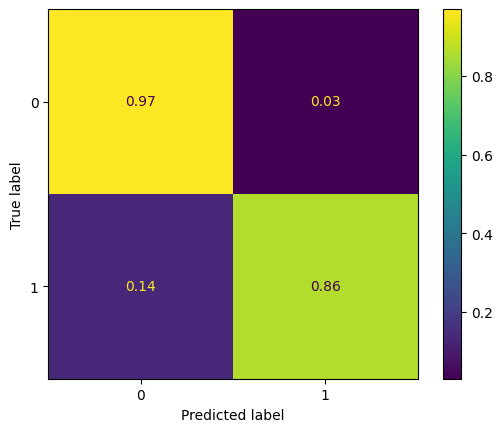

In [102]:
mods.plot_confusion_matrix(
    y_test, 
    ypred, 
    cutoff = np.sum(y_train[y_train == 1]) / len(y_train)
)

#### ROC Curve

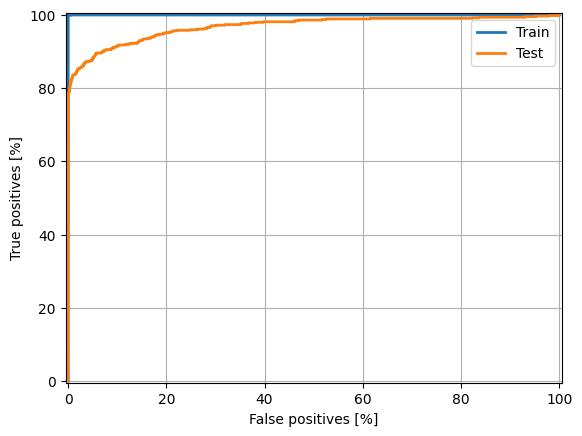

In [103]:
mods.plot_roc('Train', y_train, final_model.predict_proba(X_train)[:, 1])
mods.plot_roc('Test', y_test, ypred)
plt.legend()

#### ROC AUC

In [104]:
roc_auc_score(y_test, ypred)

0.9683451834252381

#### PR Curve

In [105]:
train_pr, train_re, _ = precision_recall_curve(y_train, final_model.predict_proba(X_train)[:, 1])
test_pr, test_re, _ = precision_recall_curve(y_test, ypred)

In [106]:
def plot_pr(names, precisions, recalls):
    fig, ax = plt.subplots()
    
    for (name, precision, recall) in zip(names, precisions, recalls):
        ax.plot(100*precision, 100*recall, label = name)
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    ax.set_title('Precision-Recall Curve')
    ax.legend()
    
    plt.show()

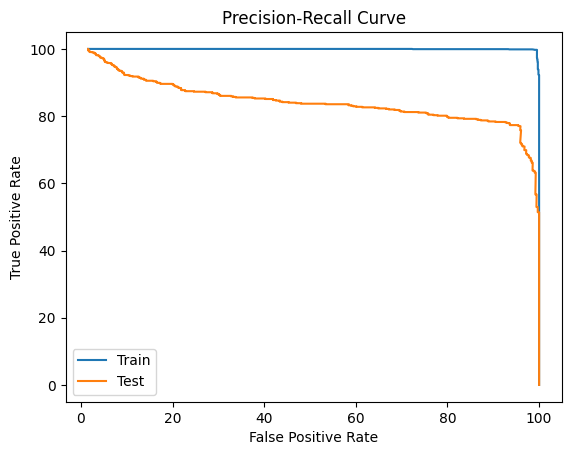

In [107]:
plot_pr(['Train', 'Test'], [train_pr, test_pr], [train_re, test_re])

#### PR AUC

In [108]:
average_precision_score(y_test, ypred)

0.8433115344218176

### Save Predictions <a id="savepreds"></a>

[Back to Model](#model)

In [109]:
test_data

id Product ID Type  Air temperature [K]  Process temperature [K]  \
0      136429     L50896    L                302.3                    311.5   
1      136430     L53866    L                301.7                    311.0   
2      136431     L50498    L                301.3                    310.4   
3      136432     M21232    M                300.1                    309.6   
4      136433     M19751    M                303.4                    312.3   
...       ...        ...  ...                  ...                      ...   
90949  227378     L51130    L                302.3                    311.4   
90950  227379     L47783    L                297.9                    309.8   
90951  227380     L48097    L                295.6                    306.2   
90952  227381     L48969    L                298.1                    307.8   
90953  227382     L52525    L                303.5                    312.8   

       Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TWF  HDF  PWF  \
0                        1499         38.0               60    0    0    0   
1                        1713         28.8               17    0    0    0   
2                        1525         37.7               96    0    0    0   
3                        1479         47.6                5    0    0    0   
4                        1515         41.3              114    0    0    0   
...                       ...          ...              ...  ...  ...  ...   
90949                    1484         40.4               15    0    0    0   
90950                    1542         33.8               31    0    0    0   
90951                    1501         41.4              187    0    0    0   
90952                    1534         40.3               69    0    0    0   
90953                    1534         36.1               92    0    0    0   

       OSF  RNF  
0        0    0  
1        0    0  
2        0    0  
3        0    0  
4        0    0  
...    ...  ...  
90949    0    0  
90950    0    0  
90951    0    0  
90952    0    0  
90953    0    0  

[90954 rows x 13 columns]

In [110]:
X = test_data[numerical_features + categorical_features]

In [111]:
y = final_model.predict_proba(X)[:, 1]

In [112]:
prediction = pd.DataFrame(
    {
        'id': test_data['id'],
        'Machine failure': y
    }
)

In [113]:
prediction.to_csv('predictions/prediction.csv', index = False)